In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np

# Load and clean data
df = pd.read_csv("/spotify_cleaned_fixed.csv")
df = df.drop(columns=['track_id', 'album_name', 'track_name', 'artists'], errors='ignore')

# Binary Encoding for 'explicit' column (True/False to 0/1)
df['explicit'] = df['explicit'].astype(int)

# One-Hot Encoding for 'track_genre' (best for nominal categorical data)
df = pd.get_dummies(df, columns=['track_genre'], prefix='genre', dtype=int)

# Keep 'mode' as binary (0 = minor, 1 = major)
# Apply cyclical encoding to 'key' (0 to 11)
df['key_sin'] = np.sin(2 * np.pi * df['key'] / 12)
df['key_cos'] = np.cos(2 * np.pi * df['key'] / 12)
df.drop(columns=['key'], inplace=True)

# Define features (X) and target (y)
X = df.drop(columns=['popularity'])
y = (df['popularity'] >= df['popularity'].median()).astype(int)  # Binary classification

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Initialize and fit scaler only on training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)    # Scale test set using scaler fitted only on training data (avoids data leakage)

# SMOTE
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)


In [ ]:
# Assuming X was originally a DataFrame
X_columns = X.columns  # save column names

# Convert scaled arrays to DataFrames for better display
X_train_df = pd.DataFrame(X_train, columns=X_columns)
X_test_df = pd.DataFrame(X_test, columns=X_columns)

# Add target back in for display purposes
train_data = X_train_df.copy()
train_data['target'] = y_train.values

test_data = X_test_df.copy()
test_data['target'] = y_test.values

In [ ]:
print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())


Training Data:
   duration_ms  explicit  danceability  energy  loudness  mode  speechiness  \
0     0.066006       0.0      0.431911   0.169  0.634704   0.0     0.032228   
1     0.061741       0.0      0.546748   0.508  0.760668   1.0     0.031088   
2     0.039033       0.0      0.648374   0.807  0.798716   0.0     0.050363   
3     0.046016       0.0      0.406504   0.484  0.795442   1.0     0.031503   
4     0.028704       0.0      0.560976   0.618  0.831363   0.0     0.032021   

   acousticness  instrumentalness  liveness  ...  genre_synth-pop  \
0      0.708835             0.335    0.0934  ...              0.0   
1      0.633534             0.000    0.1750  ...              0.0   
2      0.022992             0.000    0.3180  ...              0.0   
3      0.693775             0.000    0.1360  ...              0.0   
4      0.175703             0.000    0.1170  ...              0.0   

   genre_tango  genre_techno  genre_trance  genre_trip-hop  genre_turkish  \
0          0.0    

In [ ]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('xgb', XGBClassifier(eval_metric='logloss')),
        ('rf', RandomForestClassifier())
    ],
    voting='soft'
)

voting_clf.fit(X_train_smote, y_train_smote)
y_pred_vote = voting_clf.predict(X_test)

cm_vote = confusion_matrix(y_test, y_pred_vote)

# Detailed Results
print("**Voting Classifier Performance with SMOTE**")
print("Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_vote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Balanced Random Forest
brf_smote = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_smote.fit(X_train_smote, y_train_smote)
y_pred_brf_smote = brf_smote.predict(X_test)
cm_brf = confusion_matrix(y_test, y_pred_brf_smote)


# Results
print("\n **Balanced Random Forest Performance**")
print("Accuracy:", accuracy_score(y_test, y_pred_brf_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_brf_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_brf_smote))



 **Balanced Random Forest Performance**
Accuracy: 0.8152314217222939
Confusion Matrix:
 [[6387 1544]
 [1462 6876]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      7931
           1       0.82      0.82      0.82      8338

    accuracy                           0.82     16269
   macro avg       0.82      0.81      0.82     16269
weighted avg       0.82      0.82      0.82     16269



In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = xgb_smote.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_smote)


# Results
print("\n **XGBoost Classifier Performance with SMOTE**")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_smote))




 **XGBoost Classifier Performance with SMOTE**
Accuracy: 0.8121580920769562
Confusion Matrix:
 [[6323 1608]
 [1448 6890]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      7931
           1       0.81      0.83      0.82      8338

    accuracy                           0.81     16269
   macro avg       0.81      0.81      0.81     16269
weighted avg       0.81      0.81      0.81     16269



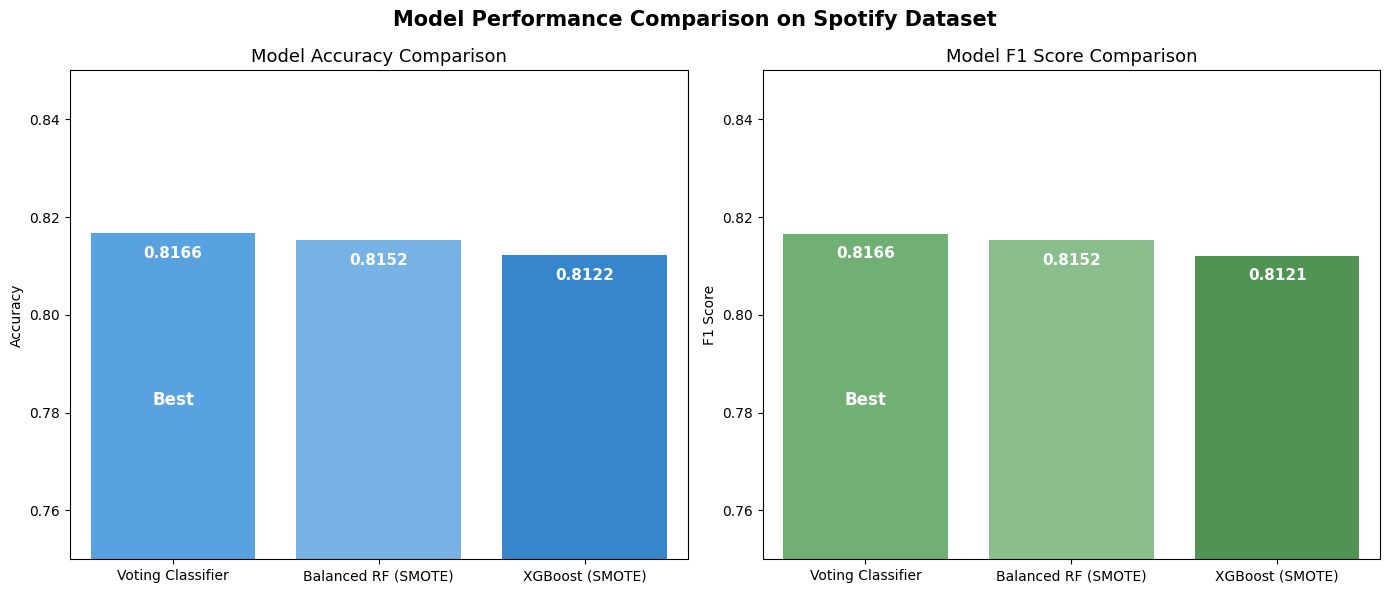

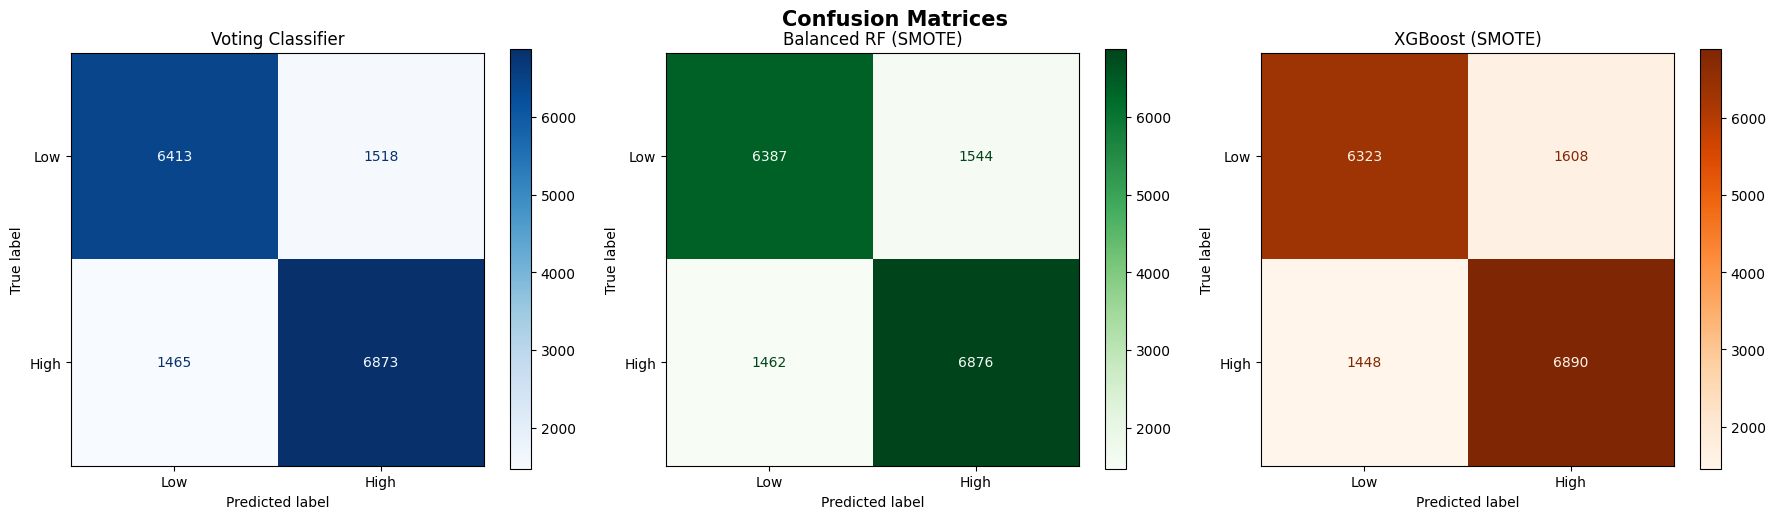

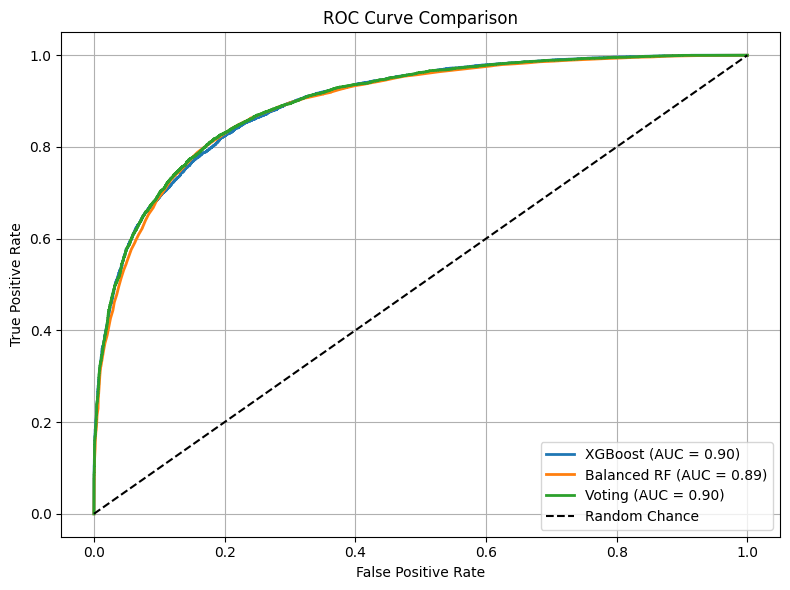

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Glyph.*missing")

# --- Predictions from SMOTE-trained models ---
y_pred_vote = voting_clf.predict(X_test)  # voting_clf trained on X_train_smote, so test set is just scaled normally
y_pred_brf_smote = brf_smote.predict(X_test)
y_pred_xgb_smote = xgb_smote.predict(X_test)

y_proba_vote = voting_clf.predict_proba(X_test)[:, 1]
y_proba_brf_smote = brf_smote.predict_proba(X_test)[:, 1]
y_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

# --- Model names ---
models = ['Voting Classifier', 'Balanced RF (SMOTE)', 'XGBoost (SMOTE)']
preds = [y_pred_vote, y_pred_brf_smote, y_pred_xgb_smote]
probas = [y_proba_vote, y_proba_brf_smote, y_proba_xgb_smote]

# --- Metrics ---
accuracies = [accuracy_score(y_test, y) for y in preds]
f1_scores = [f1_score(y_test, y, average='weighted') for y in preds]
precisions = [precision_score(y_test, y, average='weighted') for y in preds]
recalls = [recall_score(y_test, y, average='weighted') for y in preds]
aucs = [roc_auc_score(y_test, p) for p in probas]

# --- Accuracy & F1 Bar Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
acc_colors = ['#42a5f5', '#64b5f6', '#1e88e5']
f1_colors = ['#66bb6a', '#81c784', '#43a047']

sns.barplot(x=models, y=accuracies, ax=axes[0], palette=acc_colors)
axes[0].set_title("Model Accuracy Comparison", fontsize=13)
axes[0].set_ylim(0.75, 0.85)
axes[0].set_ylabel("Accuracy")
best_acc_index = accuracies.index(max(accuracies))
for i, val in enumerate(accuracies):
    axes[0].text(i, val - 0.005, f'{val:.4f}', ha='center', fontsize=11, color='white', fontweight='bold')
    if i == best_acc_index:
        axes[0].text(i, val - 0.035, 'Best', ha='center', fontsize=12, fontweight='bold', color='white')

sns.barplot(x=models, y=f1_scores, ax=axes[1], palette=f1_colors)
axes[1].set_title("Model F1 Score Comparison", fontsize=13)
axes[1].set_ylim(0.75, 0.85)
axes[1].set_ylabel("F1 Score")
best_f1_index = f1_scores.index(max(f1_scores))
for i, val in enumerate(f1_scores):
    axes[1].text(i, val - 0.005, f'{val:.4f}', ha='center', fontsize=11, color='white', fontweight='bold')
    if i == best_f1_index:
        axes[1].text(i, val - 0.035, 'Best', ha='center', fontsize=12, fontweight='bold', color='white')

plt.suptitle("Model Performance Comparison on Spotify Dataset", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


# --- Confusion Matrices ---
cm_vote = confusion_matrix(y_test, y_pred_vote)
cm_brf = confusion_matrix(y_test, y_pred_brf_smote)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_smote)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm_vote, display_labels=["Low", "High"]).plot(ax=axs[0], cmap="Blues", values_format='d')
axs[0].set_title("Voting Classifier")

ConfusionMatrixDisplay(cm_brf, display_labels=["Low", "High"]).plot(ax=axs[1], cmap="Greens", values_format='d')
axs[1].set_title("Balanced RF (SMOTE)")

ConfusionMatrixDisplay(cm_xgb, display_labels=["Low", "High"]).plot(ax=axs[2], cmap="Oranges", values_format='d')
axs[2].set_title("XGBoost (SMOTE)")

plt.suptitle("Confusion Matrices", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# --- ROC Curve Plot ---

# Compute AUC scores
auc_xgb = roc_auc_score(y_test, y_proba_xgb_smote)
auc_brf = roc_auc_score(y_test, y_proba_brf_smote)
auc_vote = roc_auc_score(y_test, y_proba_vote)

plt.figure(figsize=(8, 6))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb_smote)
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_proba_brf_smote)
fpr_vote, tpr_vote, _ = roc_curve(y_test, y_proba_vote)

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", linewidth=2)
plt.plot(fpr_brf, tpr_brf, label=f"Balanced RF (AUC = {auc_brf:.2f})", linewidth=2)
plt.plot(fpr_vote, tpr_vote, label=f"Voting (AUC = {auc_vote:.2f})", linewidth=2)

# Reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


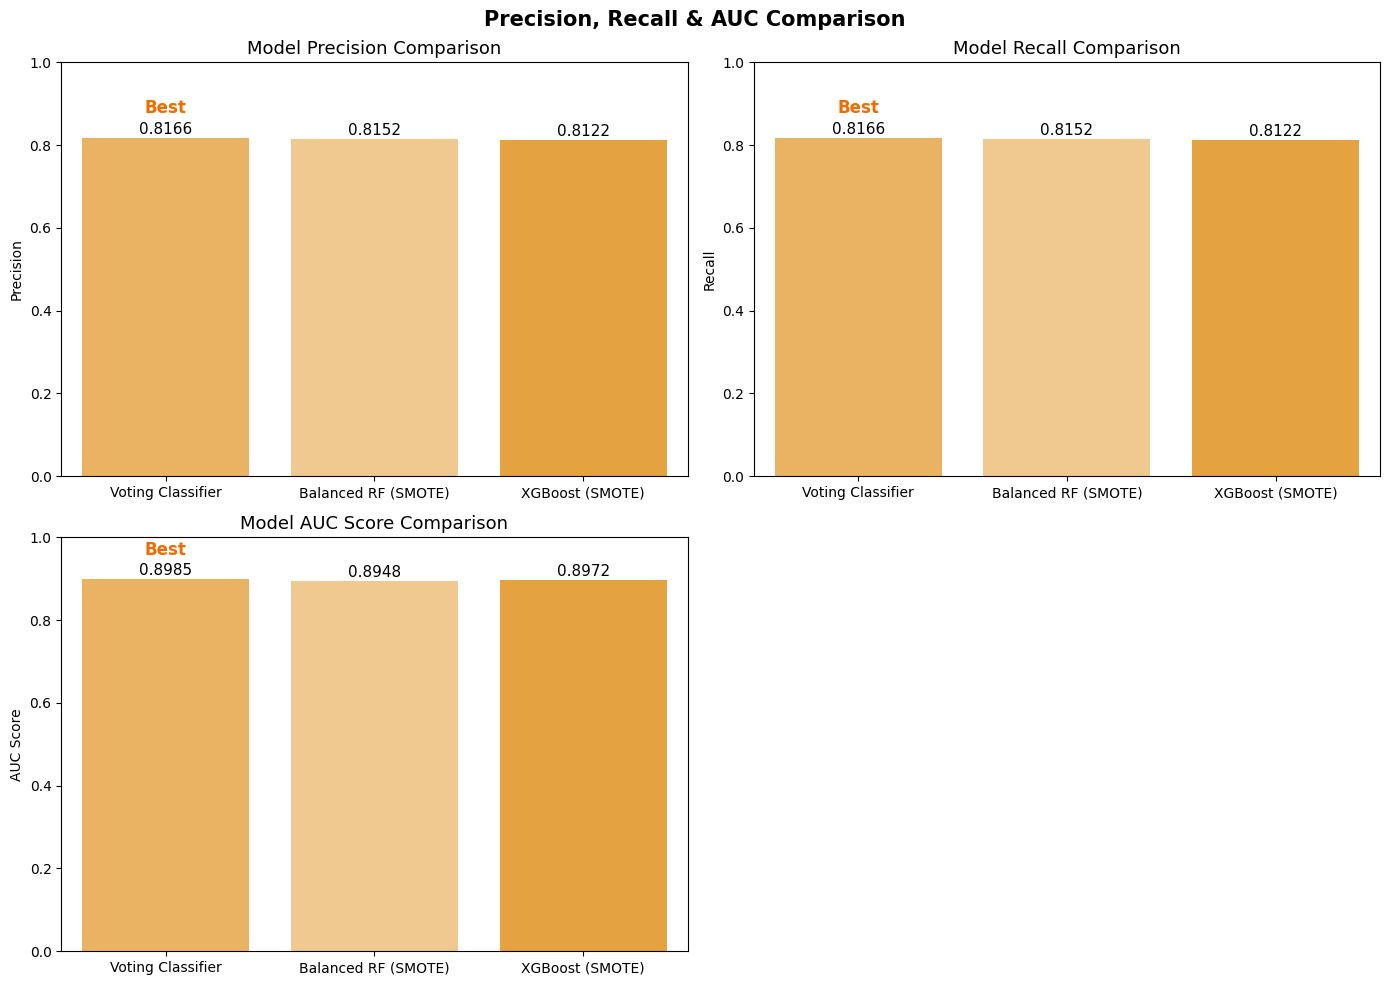

In [ ]:
# --- Collect all evaluation metrics ---
precisions = [
    classification_report(y_test, y_pred_vote, output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, y_pred_brf_smote, output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, y_pred_xgb_smote, output_dict=True)['weighted avg']['precision']
]

recalls = [
    classification_report(y_test, y_pred_vote, output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, y_pred_brf_smote, output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, y_pred_xgb_smote, output_dict=True)['weighted avg']['recall']
]


auc_scores = [auc_vote, auc_brf, auc_xgb]

# --- Create a 2x2 Grid for Extended Metric Comparison ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metric_colors = ['#ffb74d', '#ffcc80', '#ffa726']

# Precision Plot
sns.barplot(x=models, y=precisions, ax=axes[0][0], palette=metric_colors)
axes[0][0].set_title("Model Precision Comparison", fontsize=13)
axes[0][0].set_ylim(0, 1)
axes[0][0].set_ylabel("Precision")
for i, val in enumerate(precisions):
    axes[0][0].text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=11)
    if val == max(precisions):
        axes[0][0].text(i, val + 0.06, 'Best', ha='center', fontsize=12, fontweight='bold', color='#ef6c00')

# Recall Plot
sns.barplot(x=models, y=recalls, ax=axes[0][1], palette=metric_colors)
axes[0][1].set_title("Model Recall Comparison", fontsize=13)
axes[0][1].set_ylim(0, 1)
axes[0][1].set_ylabel("Recall")
for i, val in enumerate(recalls):
    axes[0][1].text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=11)
    if val == max(recalls):
        axes[0][1].text(i, val + 0.06, 'Best', ha='center', fontsize=12, fontweight='bold', color='#ef6c00')

# AUC Plot
sns.barplot(x=models, y=auc_scores, ax=axes[1][0], palette=metric_colors)
axes[1][0].set_title("Model AUC Score Comparison", fontsize=13)
axes[1][0].set_ylim(0, 1)
axes[1][0].set_ylabel("AUC Score")
for i, val in enumerate(auc_scores):
    axes[1][0].text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=11)
    if val == max(auc_scores):
        axes[1][0].text(i, val + 0.06, 'Best', ha='center', fontsize=12, fontweight='bold', color='#ef6c00')

# Turn off the unused 4th plot (bottom right)
axes[1][1].axis('off')

plt.suptitle("Precision, Recall & AUC Comparison", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()
